# Machine Learning - Practical 1 - Linear Regression

Names: {Shyam Yadav, Dipak Budha, Jack}  
Summer Term 2024   

This notebook provides you with the assignments and the overall code structure you need to complete the assignment. There are also questions that you need to answer in text form. Please use full sentences and reasonably correct spelling/grammar.

Regarding submission & grading:

- Work in groups of three and hand in your solution as a group.

- Solutions need to be uploaded to StudIP until the submission date indicated in the course plan. Please upload a copy of this notebook and a PDF version of it after you ran it.

- Solutions need to be presented to tutors in tutorial. Presentation dates are listed in the course plan. Every group member needs to be able to explain everything.

- You have to solve N-1 practicals to get admission to the exam.

- For plots you create yourself, all axes must be labeled. 

- Do not change the function interfaces.

## Imports

Jupyter Notebook provides the possibility of using libraries, functions and variables globally. This means, once you import the libraries, functions, etc. you won't have to import them again in the next cell. However, if for any reason you end the session (crash, timeout, etc.), then you'll have to run this cell to have your libraries imported again. So, let's go ahead and import whatever we need in this homework assignment.

In [37]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

## The  dataset

The dataset consists of over 20.000 materials and lists their physical features. From these features, we want to learn how to predict the critical temperature, i.e. the temperature we need to cool the material to so it becomes superconductive. First load and familiarize yourself with the data set a bit.

In [2]:
data = pd.read_csv('superconduct_train.csv')
print(data.shape)

(21263, 82)


In [3]:
data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


Because the dataset is rather large, we prepare a small subset of the data as training set, and another subset as test set. To make the computations reproducible, we set the random seed. This makes the train and test splits same even if you re-run the notebook. Keeping the splits same is important for the fair models comparison.

In [4]:
target_clm = 'critical_temp'  # the critical temperature is our target variable
n_trainset = 200  # size of the training set
n_testset = 500  # size of the test set

In [5]:
# set random seed to make sure every test set is the same and ensure reproducibility
np.random.seed(seed=1)

idx = np.arange(data.shape[0]) #generate an array of index starting from 0 for entire rows
idx_shuffled = np.random.permutation(idx)  # shuffle indices to split into training and test set

#Indexing for latter use. 
test_idx = idx_shuffled[:n_testset] #Slicing the array from beginning to 500.
train_idx = idx_shuffled[n_testset:n_testset+n_trainset] #from 500-700
train_full_idx = idx_shuffled[n_testset:] #from 500 to 20,000

#Creating test set and corresponding target values(y_test) as numpy arrays. 
X_test = data.loc[test_idx, data.columns != target_clm].values # first 500 rows, except column 'critical_temp'
y_test = data.loc[test_idx, data.columns == target_clm].values #only column 'critical_temp for first 500 row.
print('Test set shapes (X and y)', X_test.shape, y_test.shape)

#Creating train set and corresponding target train (y_train)
X_train = data.loc[train_idx, data.columns != target_clm].values
y_train = data.loc[train_idx, data.columns == target_clm].values
print('Small training set shapes (X and y):', X_train.shape, y_train.shape)

#Creating a full training set and corresponding full_target_train
X_train_full = data.loc[train_full_idx, data.columns != target_clm].values
y_train_full = data.loc[train_full_idx, data.columns == target_clm].values
print('Full training set shapes (X and y):', X_train_full.shape, y_train_full.shape)

Test set shapes (X and y) (500, 81) (500, 1)
Small training set shapes (X and y): (200, 81) (200, 1)
Full training set shapes (X and y): (20763, 81) (20763, 1)


## Task 1: Plot the dataset

To explore the dataset, use `X_train_full` and `y_train_full` for two descriptive plots:

* **Histogram** of the target variable. Use `plt.hist`.

* **Scatter plots** relating the target variable to one of the feature values. For this you will need 81 scatter plots. Arrange them in one big figure with 9x9 subplots. Use `plt.scatter`. You may need to adjust the marker size and the alpha blending value. 

Furthermore, we need to normalize the data, such that each feature has a mean of zero mean and a variance of one. Implement a function `normalize` which normalizes the data. Print the means and standard variation of the first five features before and after.

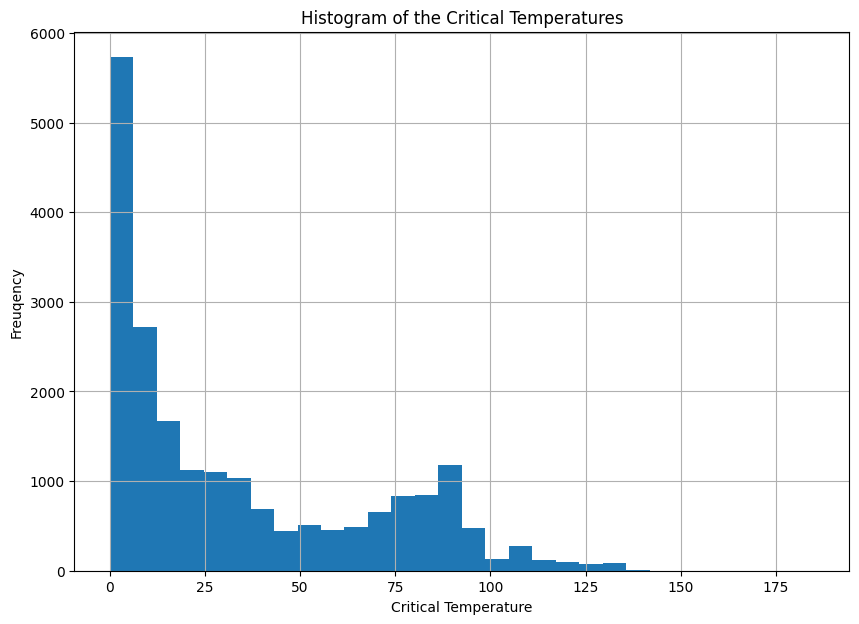

In [6]:
# Histogram of the target variable
plt.figure(figsize = (10, 7))
plt.hist(y_train_full, bins = 30)
plt.title('Histogram of the Critical Temperatures')
plt.xlabel('Critical Temperature')
plt.ylabel('Freuqency')
plt.grid(True)
plt.show()


Text(0, 0.5, 'Target (Critical Temperature)')

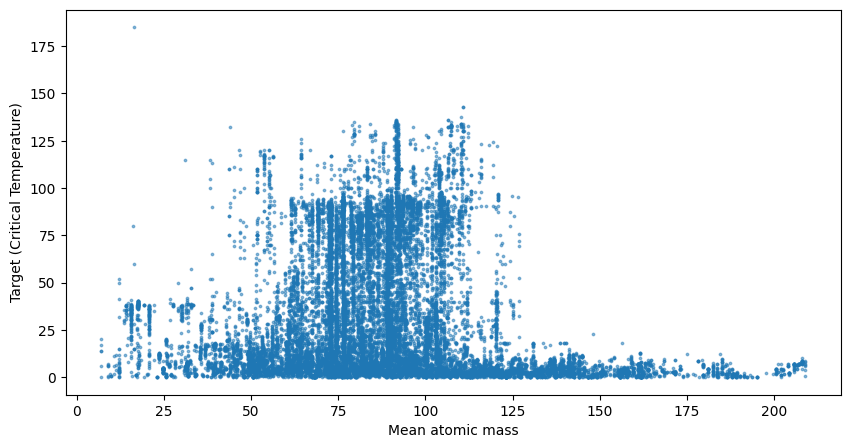

In [7]:
plt.figure(figsize=(10,5))
plt.scatter(data['mean_atomic_mass'], data[target_clm], alpha = 0.5, s= 3)
plt.xlabel("Mean atomic mass")
plt.ylabel('Target (Critical Temperature)')

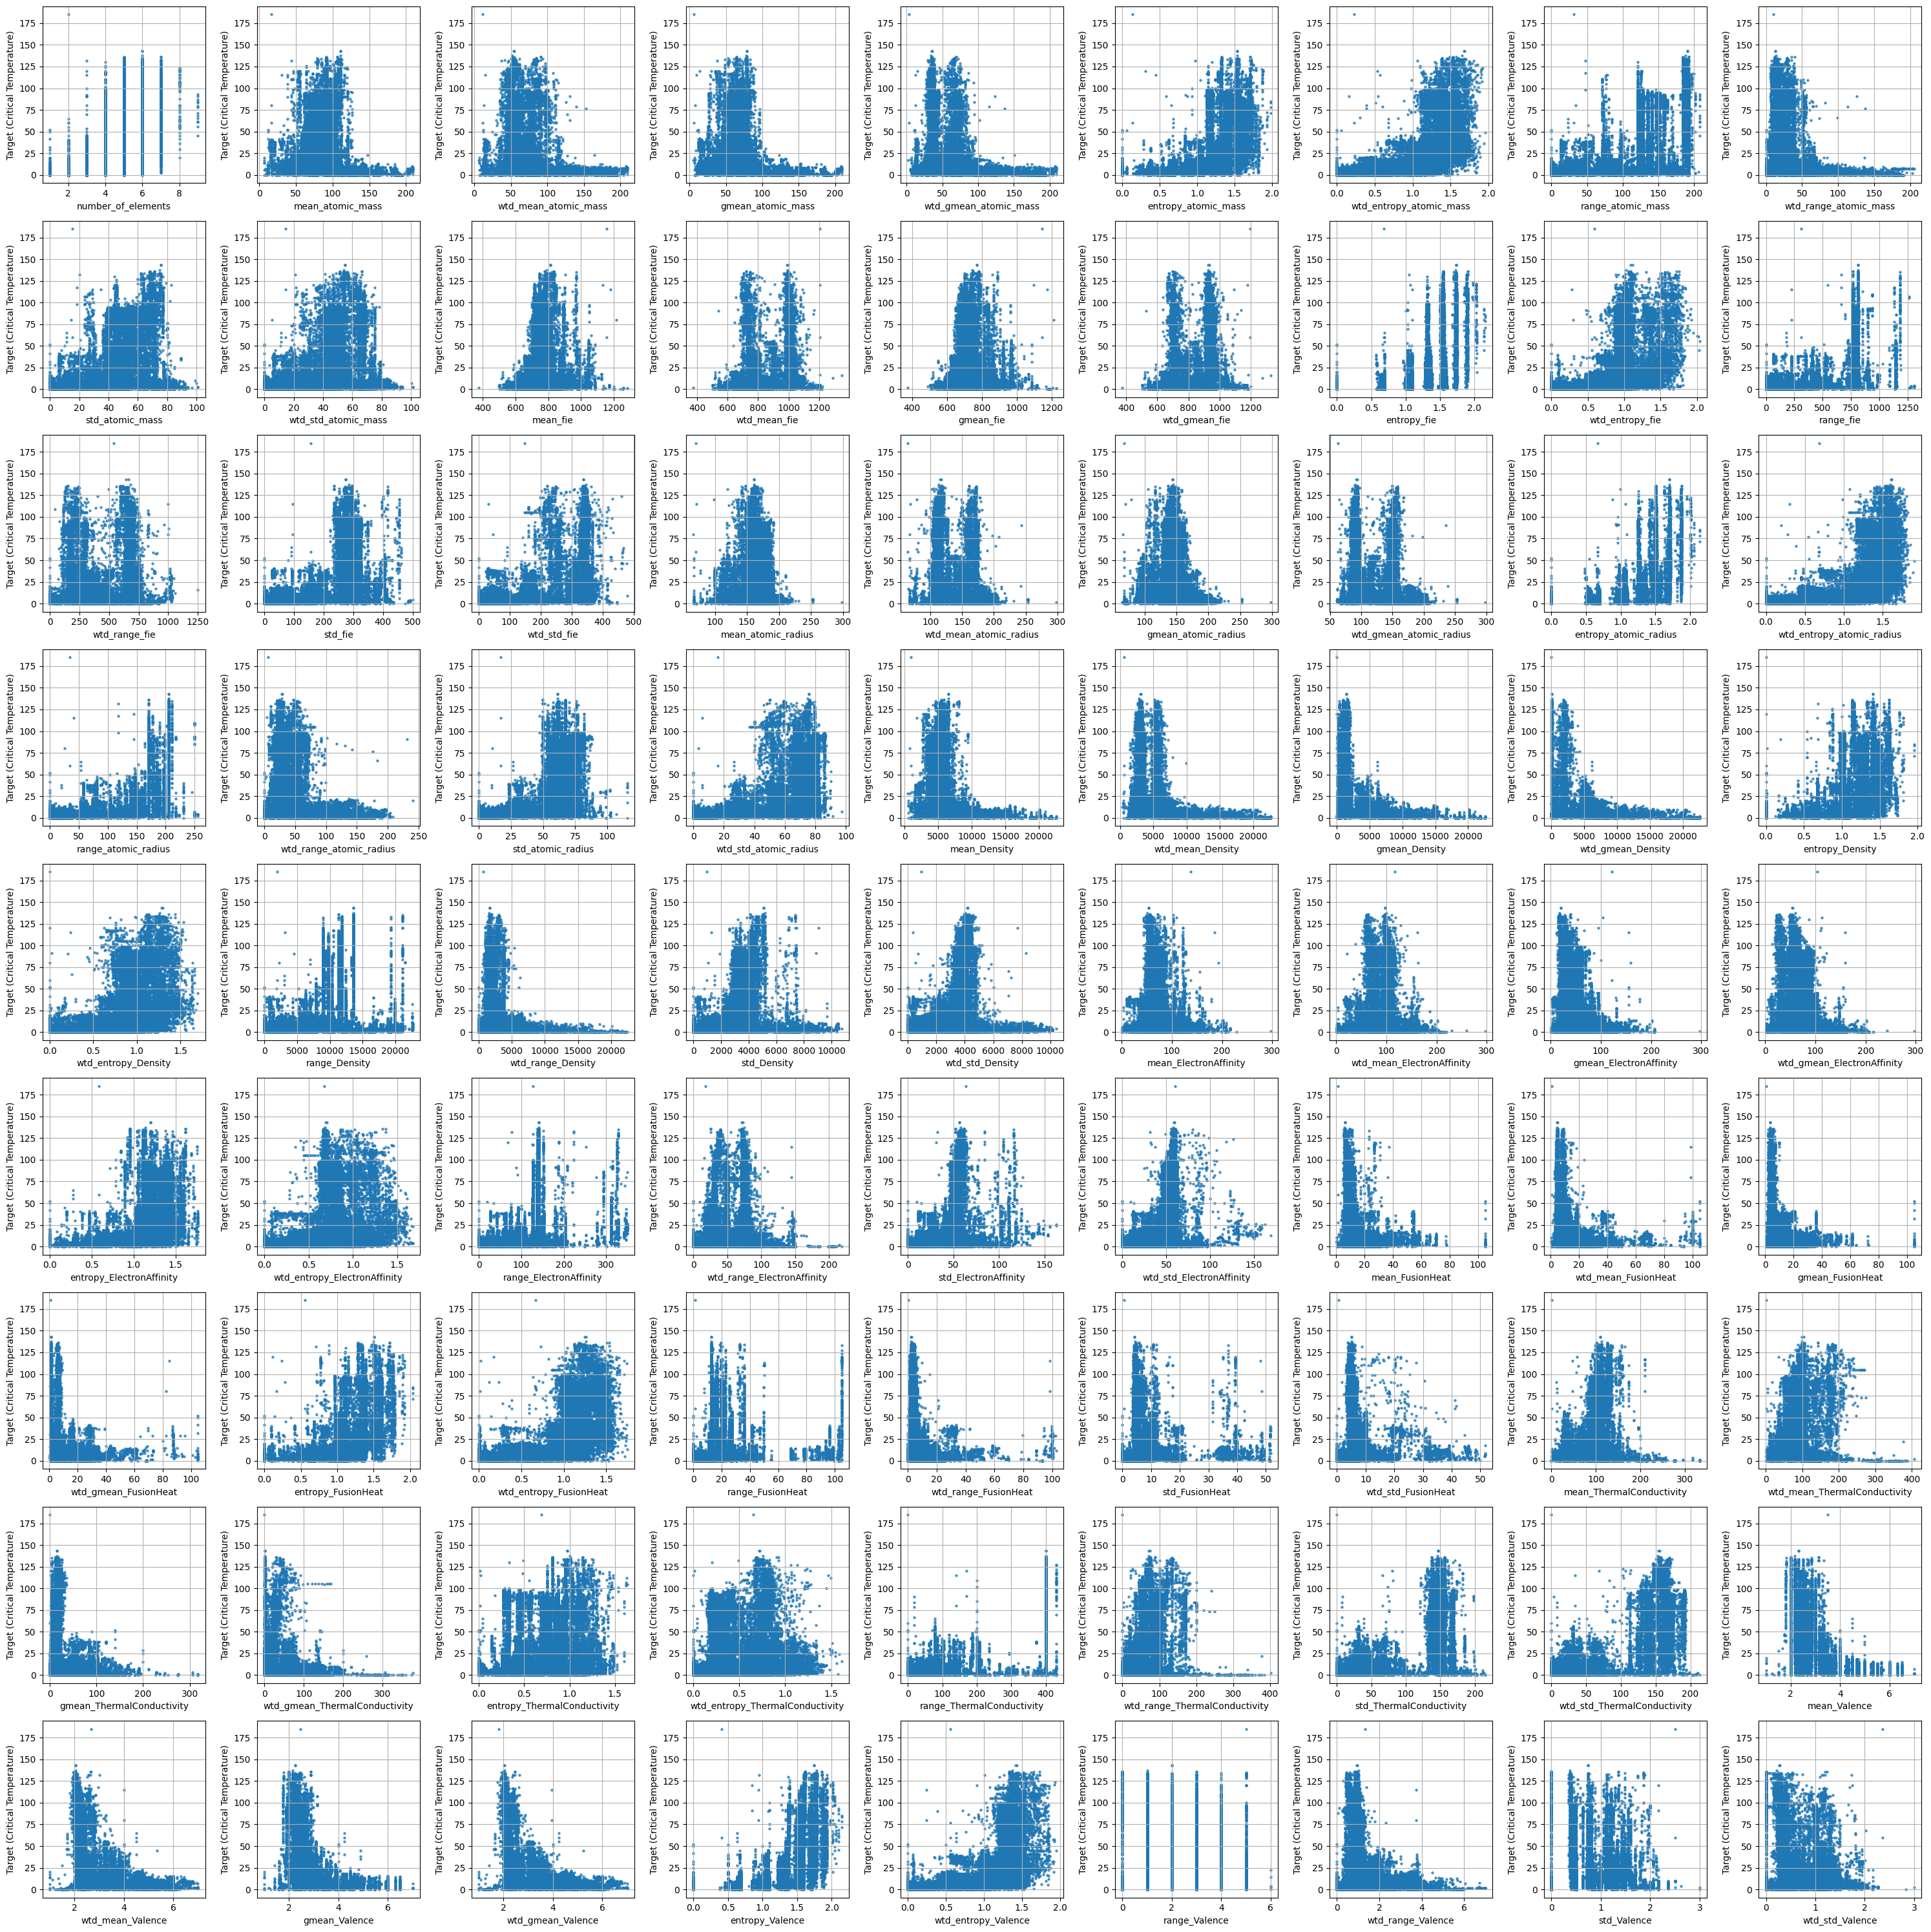

In [8]:
#crating subplots
feature_clm = data.columns
fig, axs = plt.subplots(9,9, figsize = (30,30))

#Converting multidimension array into one-dimensional for easy iteration using single index.
axs = axs.flatten()

#Plotting the target variable to the entire feature values.
for i in range(X_train_full.shape[1]): #shape 1 accesses the columns.
    axs[i].scatter(X_train_full[:,i], y_train_full, alpha = 0.7, s = 5)
    axs[i].set_xlabel(f'{feature_clm[i]}')
    axs[i].set_ylabel('Target (Critical Temperature)')
    axs[i].grid(True)
    plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
#Defining a function for normalization.
def normalize(x):
    x_mean = np.mean(x, axis = 0)
    x_std = np.std(x, axis = 0)
    x_normalized = (x - x_mean) / x_std
    return x_normalized, x_mean, x_std

#Calling the normalize function
X_train_full_normalized, X_train_full_mean_before, X_train_full_std_before = normalize(X_train_full)

means_after = np.mean(X_train_full_normalized[:, :5], axis = 0)
std_after = np.std(X_train_full_normalized[:, :5], axis = 0)

print(f'Means before normalization: {X_train_full_mean_before[:5]}')
print(f'Standard variation before normalization: {X_train_full_std_before[:5]}')

print("\nMeans after normalization:  ", ["{:.2f}".format(mean) for mean in means_after])
print('Standard deviation after normalization: ', ["{:.2f}".format(std) for std in std_after])
    

Means before normalization: [ 4.11221885 87.60808137 73.0498836  71.34256083 58.60335661]
Standard variation before normalization: [ 1.43960483 29.70299734 33.56235885 31.0755541  36.73208566]

Means after normalization:   ['-0.00', '-0.00', '0.00', '0.00', '-0.00']
Standard deviation after normalization:  ['1.00', '1.00', '1.00', '1.00', '1.00']


Which material properties may be useful for predicting superconductivity? What other observations can you make?


Answer:

After a careful inspection of the graph, we can see that the following properties of the material can be useful for predicting superconductivity.
- mean atomic mass, weighted mean atomic mass, mean atomic radius, weighted ranged fusion heat, weighted range valence, and so on can be useful for superconductivity.
- Also, we can see that the properties such as number of elements, range valence, and so on do not give any information about the superconductivity.
- Also, we can visualize the changes in the intensity of the superconductivity depending upon the individual features.
- Superconductivity is typically observed in materials at low temperatures.

 YOUR ANSWER HERE

## Task 2:  Implement your own OLS estimator

We want to use linear regression to predict the critical temperature. Implement the ordinary least squares estimator without regularization 'by hand':

$w = (X^TX)^{-1}X^Ty$

To make life a bit easier, we provide a function that can be used to plot regression results. In addition it computes the mean squared error and the squared correlation between the true and predicted values. 

In [10]:
def plot_regression_results(y_test, y_pred, weights):
    '''Produces three plots to analyze the results of linear regression:
        -True vs predicted
        -Raw residual histogram
        -Weight histogram

    Inputs:
        y_test: (n_observations,) numpy array with true values
        y_pred: (n_observations,) numpy array with predicted values
        weights: (n_weights) numpy array with regression weights'''

    print('MSE: ', mean_squared_error(y_test, y_pred))
    print('r^2: ', r2_score(y_test, y_pred))

    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    # predicted vs true
    ax[0].scatter(y_test, y_pred, s=2)
    ax[0].set_title('True vs. Predicted')
    ax[0].set_xlabel('True %s' % (target_clm))
    ax[0].set_ylabel('Predicted %s' % (target_clm))

    # residuals
    error = np.squeeze(np.array(y_test)) - np.squeeze(np.array(y_pred))
    ax[1].hist(np.array(error), bins=30)
    ax[1].set_title('Raw residuals')
    ax[1].set_xlabel('(true-predicted)')

    # weight histogram
    ax[2].hist(weights, bins=30)
    ax[2].set_title('weight histogram')

    plt.tight_layout()

As an example, we here show you how to use this function with random data. 

MSE:  17928.79570726673
r^2:  -13.313953173396845


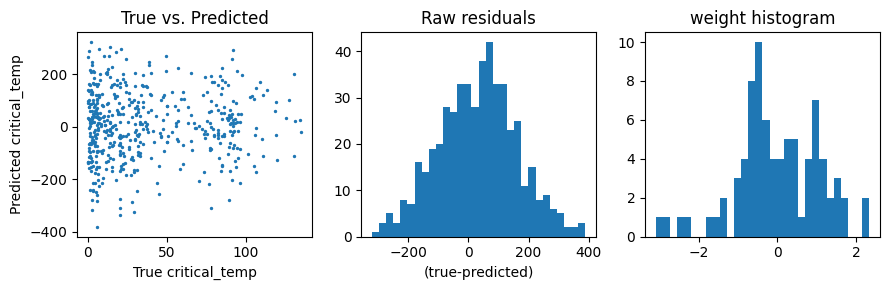

In [11]:
# weights is a vector of length 82: the first value is the intercept (beta0), then 81 coefficients
weights = np.random.randn(82)

# Model predictions on the test set
y_pred_testing = np.random.randn(y_test.size) * np.max(y_test)

plot_regression_results(y_test, y_pred_testing, weights)

Implement OLS linear regression yourself. Use `X_train` and `y_train` for estimating the weights and compute the MSE and $r^2$ from `X_test`. When you call our plotting function with the regression result, you should get mean squared error of 707.8.

In [12]:
def ols_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization on the training set and
       returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.
    '''

    #Appending a column of ones to the training and test sets
    ones_column_train = np.ones((X_train.shape[0], 1))
    ones_column_test = np.ones((X_test.shape[0], 1))
    X_train_augmented = np.hstack((X_train, ones_column_train))
    X_test_augmented = np.hstack((X_test, ones_column_test))

    #Compute OLS weights
    XTX = np.dot(X_train_augmented.T, X_train_augmented)
    XTy = np.dot(X_train_augmented.T, y_train)
    XTX_inv =np.linalg.inv(XTX)
    weights = np.dot(np.dot(XTX_inv, X_train_augmented.T), y_train)

    #Make predictions on the test set by using the formula
    y_pred = np.dot(X_test_augmented, weights)

    return weights, y_pred

In [13]:
#Implementing ordinary least squares (OLS) for estimating the weights and prediction (of critical temp.)
weights_OLS, y_pred_OLS = ols_regression(X_test, X_train, y_train)

MSE:  599.7397626064327
r^2:  0.5211810643425888


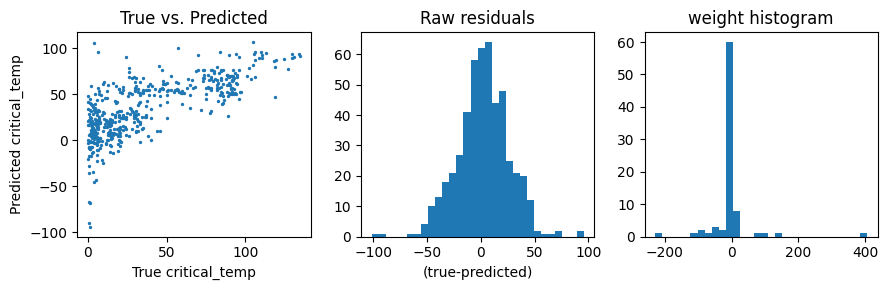

In [14]:
# Plots of the results
plot_regression_results(y_test, y_pred_OLS, weights_OLS)

What do you observe? Is the linear regression model good?

We can draw the following conclusion after implementing the ordinary least squares (OLS):
- the true critical temperature and the predicted critical temperature are in the comparable range. i.e. better results.
- The raw residuals are contracted towards 0 indicating less scattering of the data throughout the model and reducing errors.
- The weighted histogram also shows that the coefficients are more centered towards 0 and the data is improving.
- Also, if we compare the older values of MSE and $r^2$ the we can see that MSE is decreasing and the $r^2$ is in between 0 and 1.

The linear regression model is not great as we still have higher error. However, it is better than the previously randomized regression.

## Task 3: Compare your implementation to sklearn

Now, familiarize yourself with the sklearn library. In the section on linear models:

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

you will find `sklearn.linear_model.LinearRegression`, the `sklearn` implementation of the OLS estimator. Use this sklearn class to implement OLS linear regression. Again obtain estimates of the weights on `X_train` and `y_train` and compute the MSE and $r^2$ on `X_test`.


In [15]:
def sklearn_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization using the sklearn library on the training set and
       returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         The sklearn library automatically takes care of adding a column for the offset.
    '''

    model = LinearRegression().fit(X_train, y_train)
    weights = model.coef_
    y_pred = model.predict(X_test)



    return weights, y_pred

MSE:  599.7397626178176
r^2:  0.5211810643334993


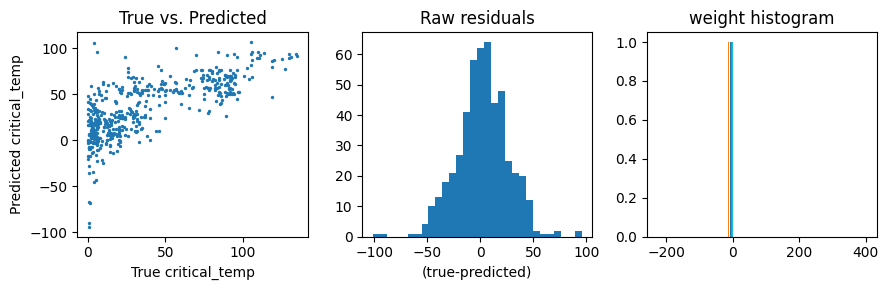

In [16]:
weights, y_pred = sklearn_regression(X_test, X_train, y_train)
plot_regression_results(y_test, y_pred, weights)

If you implemented everything correctly, the MSE is again 707.8.

Fit the model using the larger training set, `X_train_full` and `y_train_full`, and again evaluate on `X_test`.

MSE:  329.8607010409978
r^2:  0.73664652631794


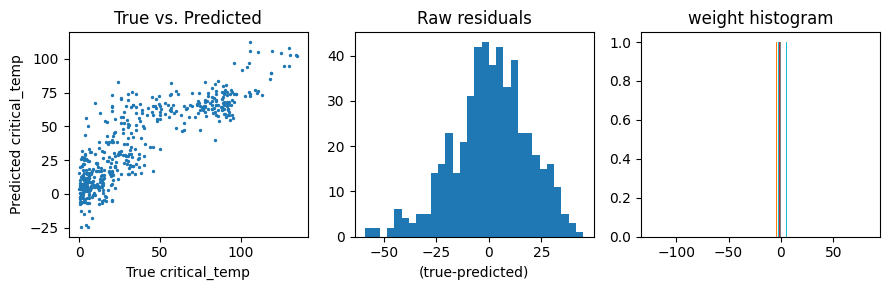

In [17]:
weights, y_pred = sklearn_regression(X_test, X_train_full, y_train_full)
plot_regression_results(y_test, y_pred, weights)

 How does test set performance change? What else changes?


So, if we train our model on a bigger data set i.e. X_train and Y_train, then we can see that the variance between the actual data and the predicted data decreases highly. Consequently, the value of MSE decreases, $r^2$ increases and the histogram of the raw residuals also gets narrowed. Thus, we can see that the prediction and the regression model gets better.

## Task 4: Regularization with ridge regression

We will now explore how a penalty term on the weights can improve the prediction quality for finite data sets. Implement the analytical solution of ridge regression 

$w = (X^TX + \alpha I_D)^{-1}X^Ty$


as a function that can take different values of $\alpha$, the regularization strength, as an input. In the lecture, this parameter was called $\lambda$, but this is a reserved keyword in Python.

In [18]:
def ridge_regression(X_test, X_train, y_train, alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha
       on the training set and returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength

       Outputs:
         weights: The weight vector for the regression model including the offset
         y_pred: The predictions on the TEST set

       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.
    '''

    
    #Appending a column of ones to the training and test sets
    ones_column_train = np.ones((X_train.shape[0], 1))
    ones_column_test = np.ones((X_test.shape[0], 1))
    X_train_augmented = np.hstack((X_train, ones_column_train))
    X_test_augmented = np.hstack((X_test, ones_column_test))

    #Compute OLS weights
    XTX = np.dot(X_train_augmented.T, X_train_augmented)
    XTy = np.dot(X_train_augmented.T, y_train)
  
    # Determining the dimension of the feature space. 
    D = X_train_augmented.shape[1]
    #Creating an identity matrix
    I_D = np.eye(D) 
    
    weights = np.dot(np.linalg.inv(XTX + alpha *I_D), XTy)
    
    #Make predictions on the test set by using the formula
    y_pred = np.dot(X_test_augmented, weights)

    return weights, y_pred

Run the ridge regression on `X_train` with an alpha value of 10 and plot the obtained weights.

MSE:  429.73785003971943
r^2:  0.6569068239306439


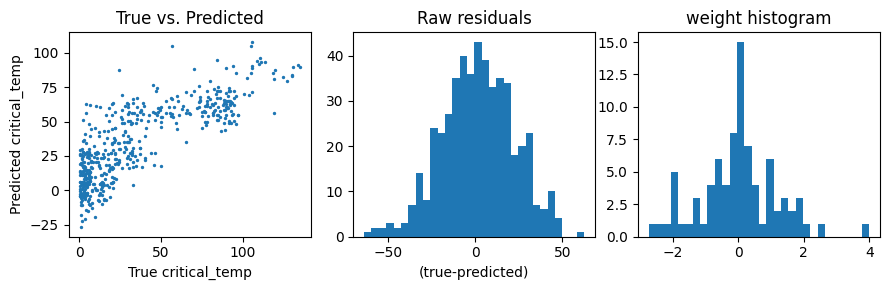

In [19]:
# Run ridge regression with alpha=10
weights, y_pred = ridge_regression(X_test, X_train, y_train, 10)

# Plot regression results
plot_regression_results(y_test, y_pred, weights)

Now test a range of log-spaced $\alpha\text{s}$ (~10-20), which cover several orders of magnitude, e.g. from 10^-7 to 10^7. 

* For each $\alpha$, you will get one model with one set of weights. 
* For each model, compute the error on the test set. 

Store both the errors and weights of all models for later use. You can use the function `mean_squared_error` from sklearn (imported above) to compute the MSE.


In [20]:
alphas = np.logspace(-7, 7, 20)

MSE_list = []
weights_list = []
for alpha in alphas:
    weights, y_pred =ridge_regression(X_test, X_train, y_train, alpha)

    MSE = mean_squared_error (y_test, y_pred)
    MSE_list.append(MSE)
    weights_list.append(weights)
    

Make a single plot that shows for each coefficient how it changes with $\alpha$, i.e. one line per coefficient. Also think about which scale is appropriate for your $\alpha$-axis. You can set this using `plt.xscale(...)`.

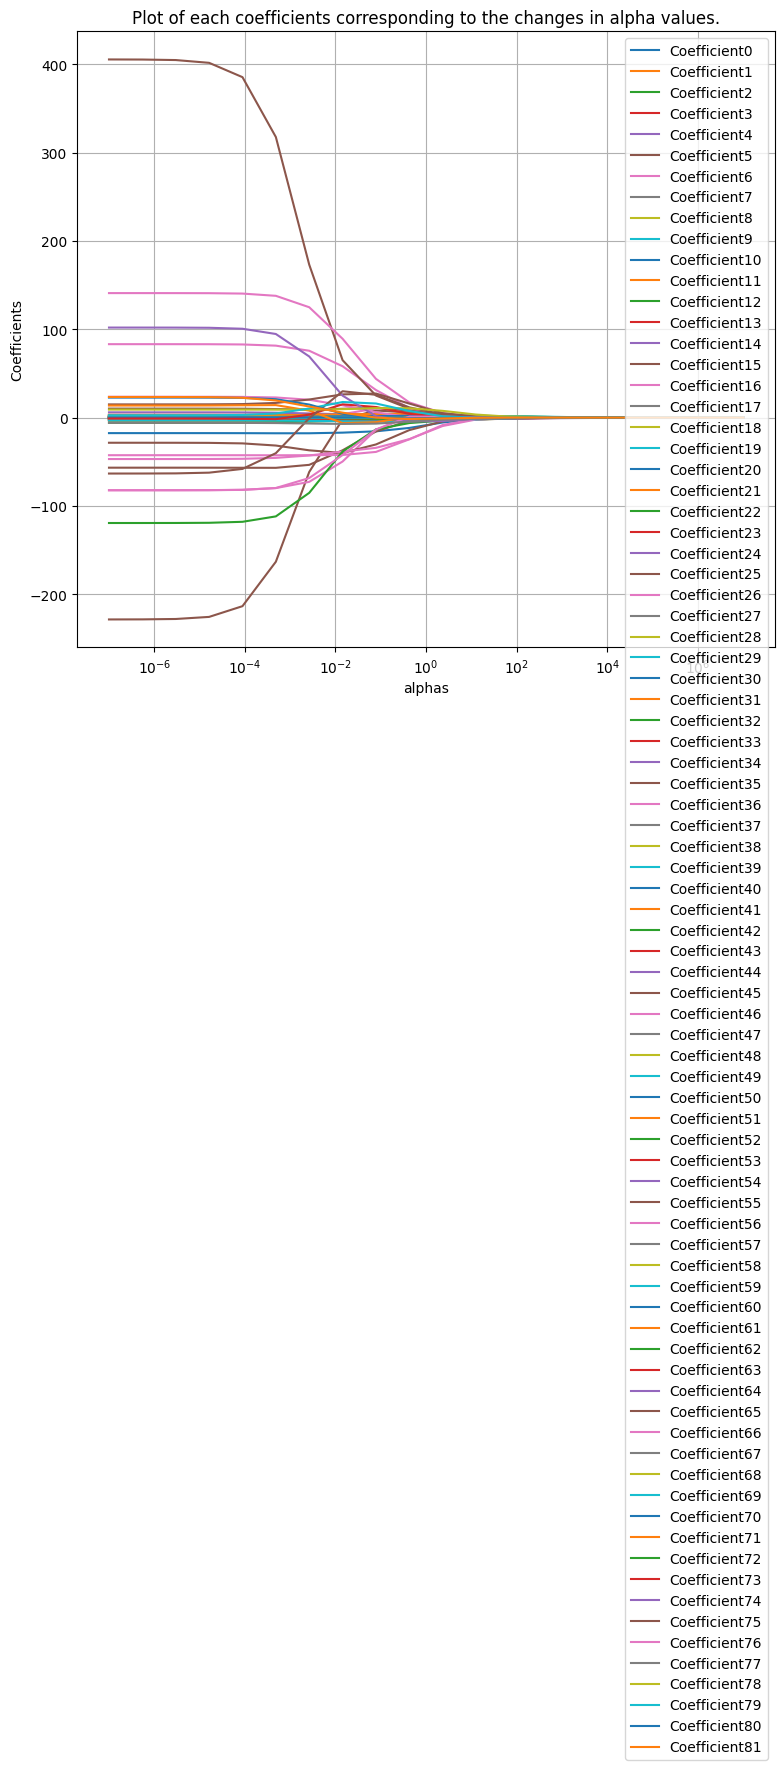

In [21]:
# Plot of coefficients vs. alphas
plt.figure(figsize = (9, 8))
weights_array = np.array(weights_list)
for i in range(weights_array.shape[1]):
    plt.plot(alphas, weights_array[:, i], label = f'Coefficient{i}')
    plt.xscale('log') #Scaling the x-axis for better visualization

plt.xlabel('alphas')
plt.ylabel('Coefficients')
plt.title("Plot of each coefficients corresponding to the changes in alpha values.")
plt.legend()
plt.grid()

Why are the values of the weights largest on the left? Do they all change monotonically? 

Smaller values of $\alpha$ corresponds to the weaker regularization whereas larger values corresponds to the bigger regularization allowing the model to fit the training data more closely. The model is penalized for large parameter values.  

Since, the values of weights decrease smoothly for larger values of $\alpha$, we can assume that all of the data change monotonically.

Plot how the performance (i.e. the error) changes as a function of $\alpha$. As a sanity check, the MSE value for very small $\alpha$ should be close to the test-set MSE of the unregularized solution, i.e. 708.

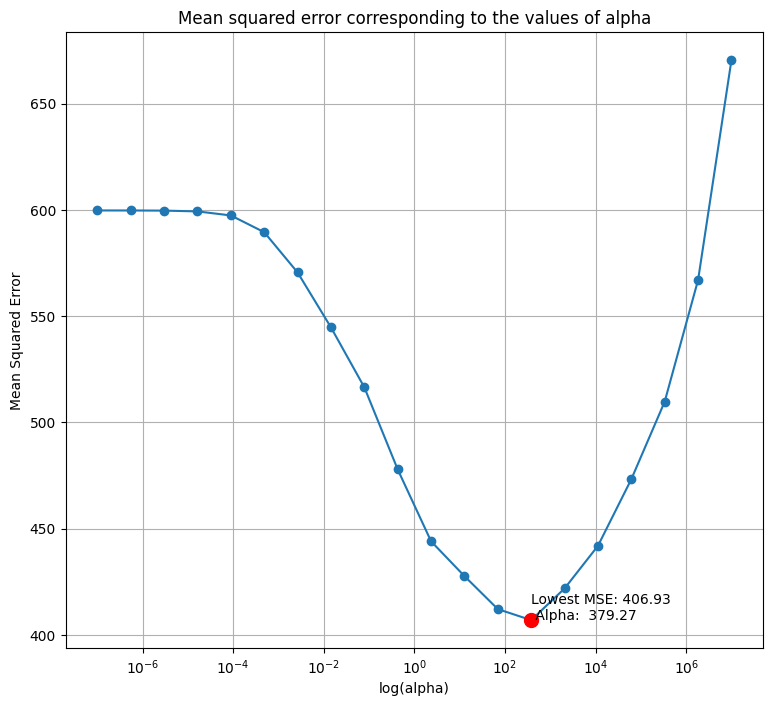

lowest mean squared error: 406.92784568224147
Corresponding logarithmic alpha: 379.26901907322383


<Figure size 640x480 with 0 Axes>

In [22]:
# Plot of MSE  vs. alphas
plt.figure(figsize=(9,8))
plt.plot(alphas, MSE_list, marker = 'o')
plt.xscale('log')

#Finding the index of the lowest value
lowest_index = MSE_list.index(min(MSE_list))
lowest_value = min(MSE_list)

plt.plot(alphas[lowest_index], lowest_value, marker = 'o', markersize =10, color = 'red')
plt.text(alphas[lowest_index], lowest_value, f'Lowest MSE:{lowest_value: .2f} \n Alpha: {alphas[lowest_index]: .2f}')

plt.xlabel("log(alpha)")
plt.ylabel("Mean Squared Error")
plt.title("Mean squared error corresponding to the values of alpha")
plt.grid()
plt.show()
plt.tight_layout()

print(f"lowest mean squared error: {lowest_value}")
print(f"Corresponding logarithmic alpha: {alphas[lowest_index]}")

Which value of $\alpha$ gives the minimum MSE? Is it better than the unregularized model? Why should the curve reach ~700 on the left?

From the above code we can see that, when $\alpha = 379.27$, it gives minimum MSE. Yeah, it seems better than unregularized since MSE is highest when unregularized. 

The curve should reach near to the 600 reange because it is the higest MSE when the model is unregularized. i.e $\alpha$ is minimum.

Now implement the same model using sklearn. Use the `linear_model.Ridge` object to do so.


In [23]:
def ridge_regression_sklearn(X_test, X_train, y_train, alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha using the sklearn
       library on the training set and returns weights and testset predictions.

       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength

       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set

       Note:
         The sklearn library automatically takes care of adding a column for the offset.
    '''

    model = Ridge(alpha)
    weights = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    return weights, y_pred

This time, only plot how the performance changes as a function of $\alpha$. 

Text(0.5, 1.0, 'Change of performance (error) as a function of alpha')

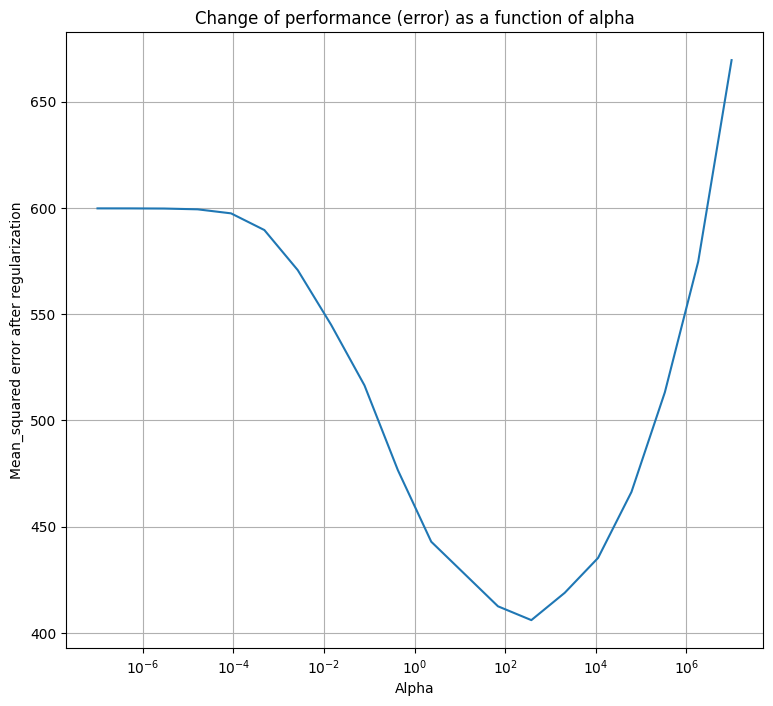

In [24]:
# Plot of MSE  vs. alphas
MSE_ridge = []
weights_ridge = []
for alpha in alphas:
    weights, y_pred = ridge_regression_sklearn(X_test, X_train, y_train, alpha)
    weights_ridge.append(weights)
    error_ridge  = mean_squared_error(y_test, y_pred)
    MSE_ridge.append(error_ridge)

plt.figure(figsize=(9,8))
plt.plot(alphas, MSE_ridge)
plt.xscale('log')
plt.grid(True)
plt.xlabel('Alpha')
plt.ylabel('Mean_squared error after regularization')
plt.title("Change of performance (error) as a function of alpha")
    
    

Note: Don't worry if the curve is not exactly identical to the one you got above. The loss function we wrote down in the lecture  has $\alpha$ defined a bit differently compared to sklearn. However, qualitatively it should look the same.

## Task 5: Cross-validation

Until now, we always estimated the error on the test set directly. However, we typically do not want to tune hyperparameters of our inference algorithms like $\alpha$ on the test set, as this may lead to overfitting. Therefore, we tune them on the training set using cross-validation. As discussed in the lecture, the training data is here split in `n_folds`-ways, where each of the folds serves as a held-out dataset in turn and the model is always trained on the remaining data. Implement a function that performs cross-validation for the ridge regression parameter $\alpha$. You can reuse functions written above.

In [25]:
kf = KFold(n_splits= 10, shuffle = True, random_state = 2)

#Splitting our data into training and validation data by its corresponding indices. 
splitted_data = kf.split(X_train) #Splitting the X_train into 10 different splits. 

#Looping through all 10 splits and storing data indices as training and validation data indices. 
for training_index, validation_index in splitted_data:
    print(f"Training indices: {training_index}")
    print(f"Validation_index: {validation_index}")
    

Training indices: [  0   1   4   5   6   7   8   9  11  15  16  17  18  19  20  21  22  23
  24  25  26  27  28  30  31  32  33  34  36  37  38  39  40  41  42  43
  45  46  47  48  49  50  51  52  53  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  86  87  88  89  90  91  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 114 116 117 118 119 120 121 122
 123 124 125 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 175 176 177 178
 179 180 181 183 184 185 186 187 188 189 190 191 192 194 195 196 197 198]
Validation_index: [  2   3  10  12  13  14  29  35  44  54  85  92 112 113 115 126 174 182
 193 199]
Training indices: [  0   1   2   3   4   5   7   8  10  11  12  13  14  15  16  17  18  19
  20  21  22  24  26  27  28  29  30  31  32  33  34  35  3

In [ ]:
def ridgeCV(X, y, n_folds, alphas):
    '''Runs a n_fold-crossvalidation over the ridge regression parameter alpha.
       The function should train the linear regression model for each fold on all values of alpha.

      Inputs:
        X: (n_obs, n_features) numpy array - predictor
        y: (n_obs,) numpy array - target
        n_folds: integer - number of CV folds
        alphas: (n_parameters,) - regularization strength parameters to CV over

      Outputs:
        cv_results_mse: (n_folds, len(alphas)) numpy array, MSE for each cross-validation fold

      Note:
        Fix the seed for reproducibility.
    '''
    #initializing the array to store MSE results
    cv_results_mse = np.zeros((n_folds, len(alphas)))
    np.random.seed(seed=2)

    kf = KFold(n_splits = n_folds)
    splitted_data = kf.split(X)

    for fold, (training_index, validation_index) in enumerate(splitted_data):
        X_train, X_val = X[training_index], X[validation_index]
        y_train, y_val = y[training_index], y[validation_index]
        
        for i, alpha in enumerate(alphas):
            #fit ridge regressioin model
            ridge = Ridge(alpha = alpha)
            ridge.fit(X_train, y_train)
            
            #predict on validation set
            y_pred = ridge.predict(X_val)
            
            #calculate mse and store
            mse = mean_squared_error(y_val, y_pred)
            cv_results_mse[fold, i] = mse

    return cv_results_mse

Now we run 10-fold cross-validation using the training data of a range of $\alpha$s.

In [ ]:

alphas = np.logspace(-7, 7, 100)
mse_cv = ridgeCV(X_train, y_train, n_folds=10, alphas=alphas)

We plot the MSE trace for each fold separately:

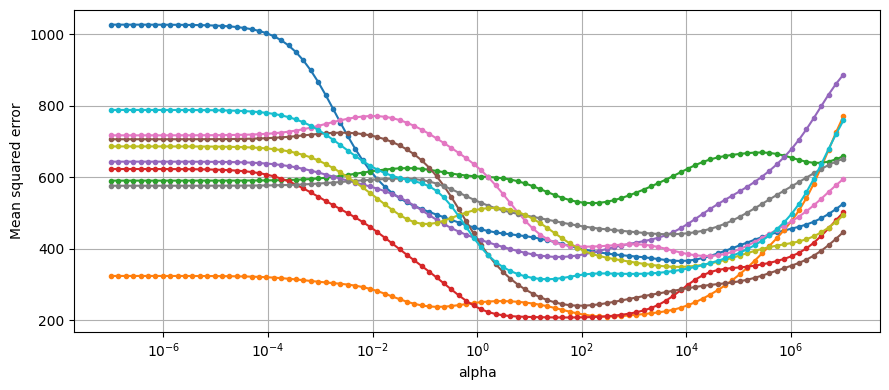

In [61]:
plt.figure(figsize = (9,4))
plt.plot(alphas, mse_cv.T, '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()
plt.grid()
plt.show()

We also plot the average across folds:

Text(1e-07, 207.86361944358333, 'Min: (1e-07, 207.86361944358333)')

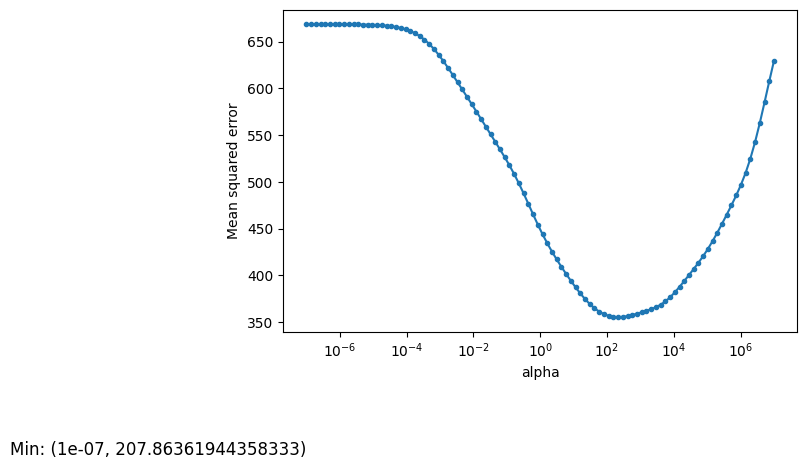

In [67]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv, axis=0), '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()
plt.text(np.min(alphas), np.min(mse_cv), f'Min: ({np.min(alphas)}, {np.min(mse_cv)})', fontsize = 12, ha = 'right')

In [71]:
#best test_set MSE
print("Best Test set MSE: ",min(MSE_ridge))
print("Best Cross Validation error: ", min (mse_cv.flatten()))

Best Test set MSE:  406.0886912144101
Best Cross Validation error:  207.86361944358333


What is the optimal $\alpha$? Is it similar to the one found on the test set? Do the cross-validation MSE and the test-set MSE match well or differ strongly?

- From the graph, we can see that the optimal value of alpha is in between $10^2$ and $10^4$. Yes, it is similar to the one found on the test set.
- From the calculation done above we can see that the cross validation MSE an the test-set MSE are similar to each other. Howevev, MSE from the cross validation is better.



We will now run cross-validation on the full training data. This will take a moment, depending on the speed of your computer. Afterwards, we will again plot the mean CV curves for the full data set (blue) and the small data set (orange).


In [72]:
alphas = np.logspace(-7, 7, 100)
mse_cv_full = ridgeCV(X_train_full, y_train_full, n_folds=10, alphas=alphas)

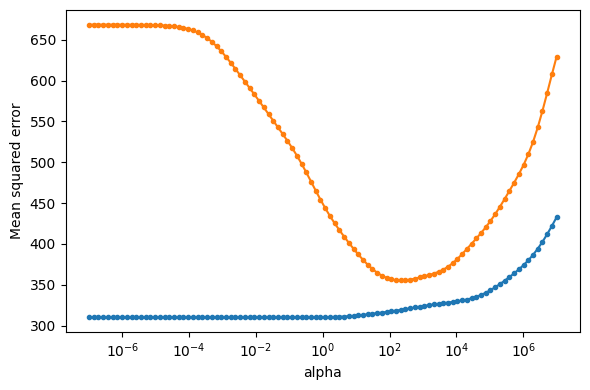

In [73]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv_full, axis=0), '.-')
plt.plot(alphas, np.mean(mse_cv, axis=0), '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

We zoom in on the blue curve to the very left:

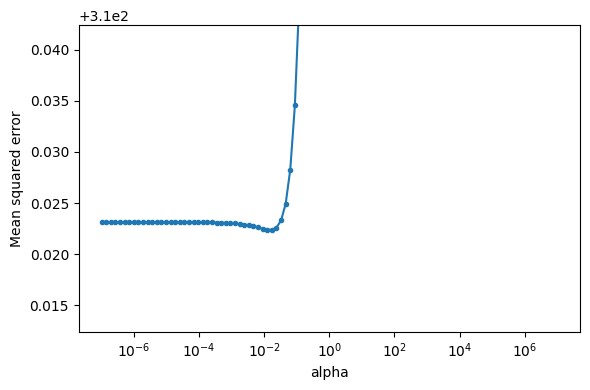

In [74]:
plt.figure(figsize=(6, 4))
plt.plot(alphas, np.mean(mse_cv_full, axis=0), '.-')
plt.xscale('log')
minValue = np.min(np.mean(mse_cv_full, axis=0))
plt.ylim([minValue-.01, minValue+.02])
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

Why does the CV curve on the full data set look so different? What is the optimal value of $\alpha$ and why is it so much smaller than on the small training set?

- The larger dataset can provide more information for the model to learn. Thus, it can have low value of apha and lower mean squared error. Also, cross validation process itself can introduce variability, especially with small datasets. Different folds of data may lead to variations in calculated error metrics and resulting curve. Thus the graph look so different.
- With more data, teh model require less regularization to prevent overfitting. A smaller $\alpha$ allows the model to fit the data more closely without penalizing  complex models as heavily.